In [1]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import re
import html
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

C:\Users\PC\AppData\Local\Temp\ipykernel_9268\3376851427.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('Suicide_Detection_final1.csv')
data

,Unnamed: 0,text,class,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,51%,68%,27%,35%,67%
1,3,Am I weird I don't get affected by compliments...,non-suicide,98%,0%,1%,17%,100%
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,89%,7%,1%,11%,56%
3,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,97%,12%,22%,26%,93%
4,19,I took the rest of my sleeping pills and my pa...,suicide,98%,69%,0%,63%,90%
...,...,...,...,...,...,...,...,...
995,2521,I'm a 17 year old senior and I sometimes feel ...,suicide,75%,37%,26%,36%,85%
996,2530,I just want to go to sleep and not wake upI ha...,suicide,76%,21%,0%,17%,97%
997,2534,Help. I'm so lost.I feel so helpless despite t...,suicide,88%,25%,18%,15%,99%
998,2535,Anybody else get really scared when you get cl...,suicide,98%,41%,49%,54%,98%


In [4]:
data_whole = pd.read_csv('Suicide_Detection.csv')
data_whole

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


<Axes: xlabel='class', ylabel='count'>

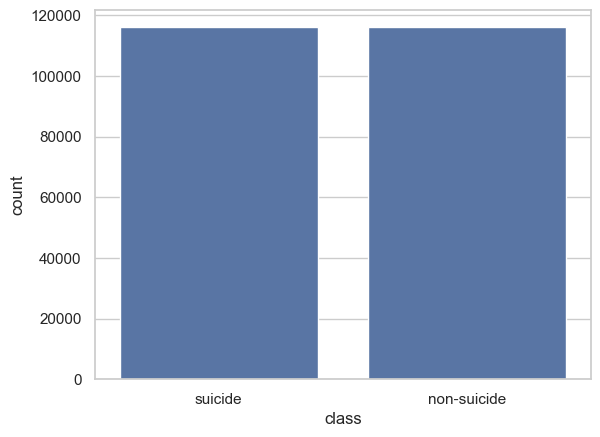

In [ ]:
#Check class distribution
sns.set_theme(style='whitegrid')
sns.countplot(data=data_whole, x='class')

Preprocessing of text

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    my_stopwords = set(stopwords.words('english'))
    add_stopwords = ['#ff', 'ff', 'rt']
    my_stopwords.update(add_stopwords)
    tokenizer = TweetTokenizer(reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Remove stop word
    tokens = [word for word in tokens if word not in my_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)

    return text

data['preprocessed_text'] = data.text.apply(preprocess_text)
data[['text','preprocessed_text']].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,weird get affected compliment coming someone k...
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone want edgy making self conscious feel ...
4,I took the rest of my sleeping pills and my pa...,took rest sleeping pill painkillersi wait end ...
5,Can you imagine getting old? Me neither.Wrinkl...,imagine getting old neither wrinkle weight gai...
6,Do you think getting hit by a train would be p...,think getting hit train would painful gun hard...
7,"death, continuedI posted here before and saw s...",death continuedi posted saw something interest...
8,Fuck the verizon smart family app I can’t even...,fuck verizon smart family app even watch porn ...
9,I’m scared. Everything just seems to be gett...,scared everything seems getting worse worse yo...


In [9]:
data_whole['preprocessed_text'] = data_whole.text.apply(preprocess_text)
data_whole[['text','preprocessed_text']].head(10)

,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,weird get affected compliment coming someone k...
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,i need helpjust help me im crying so hard,need helpjust help im cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",losthello name adam struggling year afraid pas...
5,Honetly idkI dont know what im even doing here...,honetly idki dont know im even feel like nothi...
6,[Trigger warning] Excuse for self inflicted bu...,trigger warning excuse self inflicted burn kno...
7,It ends tonight.I can’t do it anymore. \nI quit.,end tonight anymore quit
8,"Everyone wants to be ""edgy"" and it's making me...",everyone want edgy making self conscious feel ...
9,My life is over at 20 years oldHello all. I am...,life year oldhello year old balding male hairl...


In [10]:
data_whole.to_csv("processed_data.csv", index=False)

In [2]:
data_whole = pd.read_csv("processed_data.csv")

# Display the first few rows
print(data_whole.head())

   Unnamed: 0                                               text        class  \
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide   
1           3  Am I weird I don't get affected by compliments...  non-suicide   
2           4  Finally 2020 is almost over... So I can never ...  non-suicide   
3           8          i need helpjust help me im crying so hard      suicide   
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide   

                                   preprocessed_text  
0  ex wife threatening suiciderecently left wife ...  
1  weird get affected compliment coming someone k...  
2  finally almost never hear bad year ever swear ...  
3                     need helpjust help im cry hard  
4  losthello name adam struggling year afraid pas...  


#Feature extraction & Modeling


Word2Vec + CNN-BiLSTM (1000)

In [4]:
# Convert class labels into numbers
y = data['class'].map({'suicide': 1, 'non-suicide': 0})

# Train set and test set split
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'], y, test_size=0.2, random_state=42)

In [5]:
from gensim.models import KeyedVectors

# Creat word index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text into sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum sequence length
max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

# Fill sequence
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Load GoogleNews pre-trained word vectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Get the size of the vocabulary
num_words = len(tokenizer.word_index) + 1

# Create the word embedding matrix
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [6]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert the labels to one-hot encoding
num_classes = 2
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

# Construct the model
embedding_dim = 300
filters = 100
kernel_size = 5
lstm_units = 100
dropout_rate = 0.3

model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True)))
model.add(LSTM(lstm_units))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Train the model
batch_size = 64
epochs = 5

model.fit(X_train_padded, y_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_padded, y_test_onehot))

# Evaluate the model
# Make predictions on the test data
lstm_y_prob = model.predict(X_test_padded)
# Find the class index with the maximum probability
lstm_y_pred = np.argmax(lstm_y_prob, axis=1)
# Convert one-hot-encoded test labels to category indices
y_test = np.argmax(y_test_onehot, axis=1)

print('Word2Vec + CNN-BiLSTM Results:')
print(classification_report(y_test, lstm_y_pred, digits=4))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 117, 300)          1419600   
                                                                 
 conv1d (Conv1D)             (None, 113, 100)          150100    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 56, 100)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 56, 200)          160800    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 64)                6

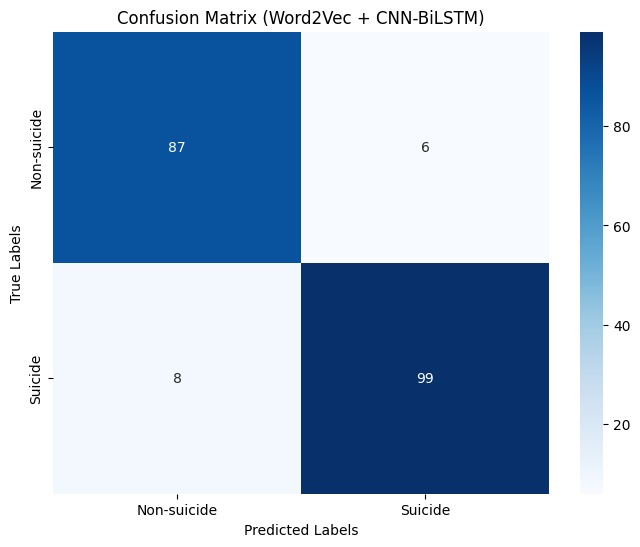

In [7]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, lstm_y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM)')
plt.show()

Word2Vec + CNN-BiLSTM (Whole)

In [10]:
y_whole = data_whole['class'].map({'suicide': 1, 'non-suicide': 0})

# Train set and test set split
X_train_whole, X_test_whole, y_train_whole, y_test_whole = train_test_split(data_whole['preprocessed_text'], y_whole, test_size=0.2, random_state=42)

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from gensim.models import KeyedVectors

X_train_whole = X_train_whole.astype(str)  # Convert everything to string
X_test_whole = X_test_whole.astype(str)  # Convert everything to string

# Creat word index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_whole)

# Convert text into sequence
X_train_seq = tokenizer.texts_to_sequences(X_train_whole)
X_test_seq = tokenizer.texts_to_sequences(X_test_whole)

# Determine the maximum sequence length
max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

# Fill sequence
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Load GoogleNews pre-trained word vectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Get the size of the vocabulary
num_words = len(tokenizer.word_index) + 1

# Create the word embedding matrix
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [9]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Dropout, CuDNNLSTM
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

y_train_whole = np.array(y_train_whole)
y_test_whole = np.array(y_test_whole)

# Convert the labels to one-hot encoding
num_classes = 2
y_train_onehot = to_categorical(y_train_whole, num_classes)
y_test_onehot = to_categorical(y_test_whole, num_classes)

# Construct the model
embedding_dim = 300
filters = 100
kernel_size = 5
lstm_units = 100
dropout_rate = 0.3

model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D())
model.add(Bidirectional(CuDNNLSTM(lstm_units, return_sequences=True))) #use GPU for large dataset
model.add(Dropout(dropout_rate))
model.add(CuDNNLSTM(lstm_units))
model.add(Dropout(dropout_rate))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Train the model
batch_size = 64
epochs = 5
with tf.device('/GPU:0'):
    model.fit(X_train_padded, y_train_onehot,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test_padded, y_test_onehot))

# Evaluate the model
# Make predictions on the test data
lstm_y_prob = model.predict(X_test_padded)
# Find the class index with the maximum probability
lstm_y_pred = np.argmax(lstm_y_prob, axis=1)
# Convert one-hot-encoded test labels to category indices
y_test = np.argmax(y_test_onehot, axis=1)

print('(Whole) Word2Vec + CNN-BiLSTM Results:')
print(classification_report(y_test, lstm_y_pred, digits=4))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5850, 300)         34198200  
                                                                 
 conv1d_2 (Conv1D)           (None, 5846, 100)         150100    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2923, 100)        0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 2923, 200)        161600    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 2923, 200)         0         
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 100)              

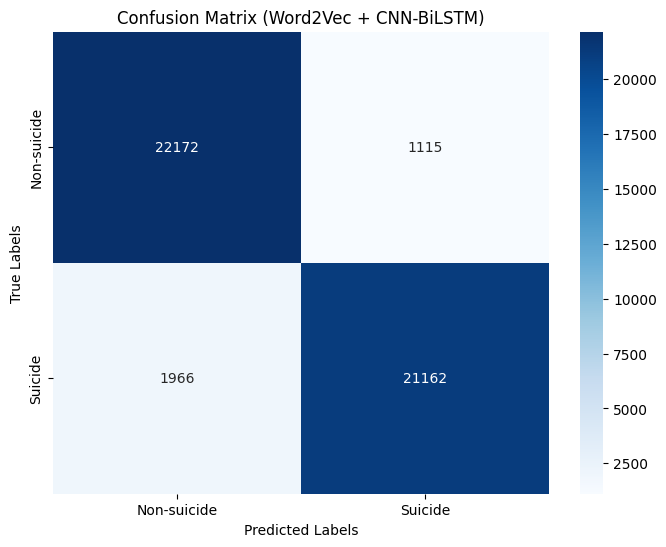

In [10]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, lstm_y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM)')
plt.show()

Word2Vec + CNN-BiLSTM + Attention (1000)

In [8]:
from gensim.models import KeyedVectors

# Creat word index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text into sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum sequence length
max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

# Fill sequence
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Load GoogleNews pre-trained word vectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Get the size of the vocabulary
num_words = len(tokenizer.word_index) + 1

# Create the word embedding matrix
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [11]:
import numpy as np
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Attention, Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Multiply, Flatten, BatchNormalization
from keras.layers import Layer
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical

# Convert the labels to one-hot encoding
num_classes = 2
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

# Model Parameters (as reference)
embedding_dim = 300
filters = 128
kernel_size = 5
lstm_units = 64
dropout_rate = 0.5
l2_lambda = 0.01
learning_rate = 0.0001

# Define Model
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs)

conv_layer = Conv1D(filters, kernel_size, activation='relu', kernel_regularizer=l2(l2_lambda))(embedding_layer)
pooling_layer = MaxPooling1D()(conv_layer)

bilstm_layer = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True, kernel_regularizer=l2(l2_lambda)))(pooling_layer)

# Built-in Attention Layer
attention_layer = Attention()([bilstm_layer, bilstm_layer])  

flatten_layer = Flatten()(attention_layer)
bn_layer = BatchNormalization()(flatten_layer)
dense1 = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(bn_layer)
dropout1 = Dropout(dropout_rate)(dense1)
dense2 = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(dropout1)
dropout2 = Dropout(dropout_rate)(dense2)
output_layer = Dense(2, activation='softmax', kernel_regularizer=l2(l2_lambda))(dropout2)

# Compile Model
model = Model(inputs=inputs, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

# Train the model
batch_size = 512
epochs = 40
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model.fit(X_train_padded, y_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_padded, y_test_onehot),
          callbacks=[early_stopping])

# Evaluate the model
lstm2_y_prob = model.predict(X_test_padded)
lstm2_y_pred = np.argmax(lstm2_y_prob, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

print('Word2Vec + CNN-BiLSTM with Attention Results:')
print(classification_report(y_test, lstm2_y_pred, digits=4))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 117)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 117, 300)     1419600     ['input_2[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 113, 128)     192128      ['embedding_2[0][0]']            
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 56, 128)     0           ['conv1d_2[0][0]']               
                                                                                            

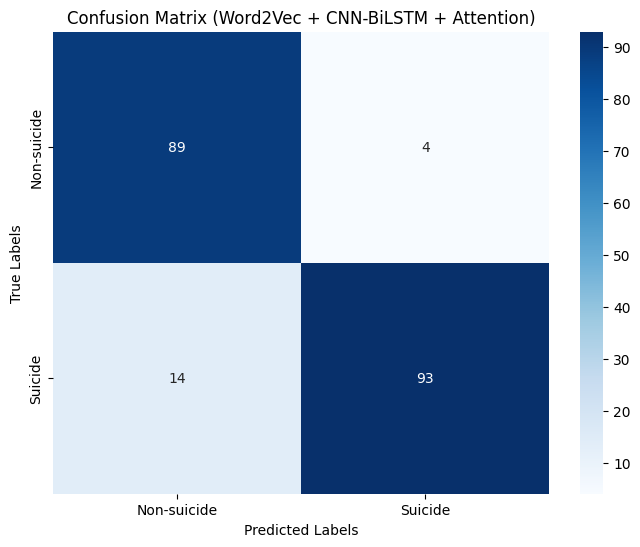

In [12]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, lstm2_y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM + Attention)')
plt.show()

Word2Vec + CNN-BiLSTM + Attention (Whole)

In [24]:
from gensim.models import KeyedVectors

X_train_whole = X_train_whole.astype(str)  # Convert everything to string
X_test_whole = X_test_whole.astype(str)  # Convert everything to string

# Creat word index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_whole)

# Convert text into sequence
X_train_seq = tokenizer.texts_to_sequences(X_train_whole)
X_test_seq = tokenizer.texts_to_sequences(X_test_whole)

# Determine the maximum sequence length
max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

# Fill sequence
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Load GoogleNews pre-trained word vectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Get the size of the vocabulary
num_words = len(tokenizer.word_index) + 1

# Create the word embedding matrix
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [27]:
import numpy as np
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Attention, Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, CuDNNLSTM, Dense, Dropout, Multiply, Flatten, BatchNormalization
from keras.layers import Layer
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical

# Convert the labels to one-hot encoding
num_classes = 2
y_train_onehot = to_categorical(y_train_whole, num_classes)
y_test_onehot = to_categorical(y_test_whole, num_classes)

# Model Parameters (as reference)
embedding_dim = 300
filters = 128
kernel_size = 5
lstm_units = 64
dropout_rate = 0.5
l2_lambda = 0.01
learning_rate = 0.0001

# Define Model
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs)

conv_layer = Conv1D(filters, kernel_size, activation='relu', kernel_regularizer=l2(l2_lambda))(embedding_layer)
pooling_layer = MaxPooling1D()(conv_layer)

bilstm_layer = Bidirectional(CuDNNLSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(l2_lambda)))(pooling_layer)

# Built-in Attention Layer
attention_layer = Attention()([bilstm_layer, bilstm_layer])  

flatten_layer = Flatten()(attention_layer)
bn_layer = BatchNormalization()(flatten_layer)
dense1 = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(bn_layer)
dropout1 = Dropout(dropout_rate)(dense1)
dense2 = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(dropout1)
dropout2 = Dropout(dropout_rate)(dense2)
output_layer = Dense(2, activation='softmax', kernel_regularizer=l2(l2_lambda))(dropout2)

# Compile Model
model = Model(inputs=inputs, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

# Train the model
batch_size = 512
epochs = 40
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model.fit(X_train_padded, y_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_padded, y_test_onehot),
          callbacks=[early_stopping])

# Evaluate the model
lstm_y_prob = model.predict(X_test_padded)
lstm_y_pred = np.argmax(lstm_y_prob, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

print('Word2Vec + CNN-BiLSTM with Attention Results:')
print(classification_report(y_test, lstm2_y_pred, digits=4))


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 5850)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 5850, 300)    34198200    ['input_5[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 5846, 128)    192128      ['embedding_4[0][0]']            
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 2923, 128)   0           ['conv1d_4[0][0]']               
                                                                                            

KeyboardInterrupt: 

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, lstm_y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ((Whole) Word2Vec + CNN-BiLSTM + Attention)')
plt.show()

BERT (1000)

In [5]:
# BERT preprocessor does not require stopword, punctuation removal or tokenization, lemmatization
def preprocess_bert(text):
    tokenizer = TweetTokenizer(reduce_len=True)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Lowercasing
    text = text.lower()

    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in ['"','#ff', 'ff', 'rt']]
    text = ' '.join(tokens)

    return text

data['preprocessed_text_bert'] = data.text.apply(preprocess_bert)
data[['text','preprocessed_text_bert']].head(10)

,text,preprocessed_text_bert
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently i left my ...
1,Am I weird I don't get affected by compliments...,am i weird i don't get affected by compliments...
2,Finally 2020 is almost over... So I can never ...,finally 2020 is almost over ... so i can never...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone wants to be edgy and it's making me s...
4,I took the rest of my sleeping pills and my pa...,i took the rest of my sleeping pills and my pa...
5,Can you imagine getting old? Me neither.Wrinkl...,can you imagine getting old ? me neither.wrink...
6,Do you think getting hit by a train would be p...,do you think getting hit by a train would be p...
7,"death, continuedI posted here before and saw s...","death , continuedi posted here before and saw ..."
8,Fuck the verizon smart family app I can’t even...,fuck the verizon smart family app i can ’ t ev...
9,I’m scared. Everything just seems to be gett...,i ’ m scared . everything just seems to be get...


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score

texts = data['preprocessed_text_bert']
labels = data['class'].map({'suicide': 1, 'non-suicide': 0})
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = train_test_split(dataset, test_size=val_size)

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8
)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)
optimizer = AdamW(model.parameters(), lr=1e-6)

# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(10):
    # train loop
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs.logits, b_labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} finished.")

    # validation loop
    model.eval()
    val_labels = []
    val_preds = []
    val_probs = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate probabilities for roc_auc_score
        probs = torch.nn.functional.softmax(torch.from_numpy(logits), dim=1).numpy()
        val_probs.extend(probs)

        predictions = np.argmax(logits, axis=1)
        val_labels.extend(label_ids)
        val_preds.extend(predictions)

print('BERT Results:')
print(classification_report(val_labels, val_preds, digits=4))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 finished.
Epoch 2 finished.
Epoch 3 finished.
Epoch 4 finished.
Epoch 5 finished.
Epoch 6 finished.
Epoch 7 finished.
Epoch 8 finished.
Epoch 9 finished.
Epoch 10 finished.
BERT Results:
              precision    recall  f1-score   support

           0     0.9684    0.9020    0.9340       102
           1     0.9048    0.9694    0.9360        98

    accuracy                         0.9350       200
   macro avg     0.9366    0.9357    0.9350       200
weighted avg     0.9372    0.9350    0.9350       200



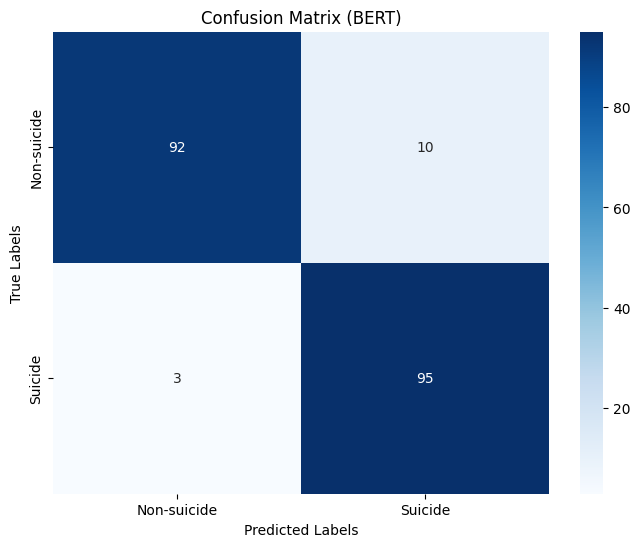

In [8]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT)')
plt.show()

BERT (Whole)

In [3]:
# BERT preprocessor does not require stopword, punctuation removal or tokenization, lemmatization
def preprocess_bert_whole_dataset(text):
    tokenizer = TweetTokenizer(reduce_len=True)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Lowercasing
    text = text.lower()

    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in ['"','#ff', 'ff', 'rt']]
    text = ' '.join(tokens)

    return text

data_whole['preprocessed_text_bert'] = data_whole.text.apply(preprocess_bert_whole_dataset)
data_whole[['text','preprocessed_text_bert']].head(10)

,text,preprocessed_text_bert
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently i left my ...
1,Am I weird I don't get affected by compliments...,am i weird i don't get affected by compliments...
2,Finally 2020 is almost over... So I can never ...,finally 2020 is almost over ... so i can never...
3,i need helpjust help me im crying so hard,i need helpjust help me im crying so hard
4,"I’m so lostHello, my name is Adam (16) and I’v...","i ’ m so losthello , my name is adam ( 16 ) an..."
5,Honetly idkI dont know what im even doing here...,honetly idki dont know what im even doing here...
6,[Trigger warning] Excuse for self inflicted bu...,[ trigger warning ] excuse for self inflicted ...
7,It ends tonight.I can’t do it anymore. \nI quit.,it ends tonight . i can ’ t do it anymore . i ...
8,"Everyone wants to be ""edgy"" and it's making me...",everyone wants to be edgy and it's making me s...
9,My life is over at 20 years oldHello all. I am...,my life is over at 20 years oldhello all . i a...


In [5]:
#Save the encoded data
import torch
from transformers import BertTokenizerFast

texts = data_whole['preprocessed_text_bert'].tolist()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# tokenize and encode sequences in the training set
encoded_data = tokenizer(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

torch.save(encoded_data, "encoded_data.pt")  # Save
encoded_data = torch.load("encoded_data.pt")  # Load

print(encoded_data)  # Verify


{'input_ids': tensor([[  101,  4654,  2564,  ...,     0,     0,     0],
        [  101,  2572,  1045,  ...,     0,     0,     0],
        [  101,  2633, 12609,  ...,     0,     0,     0],
        ...,
        [  101, 21392,  2763,  ...,     0,     0,     0],
        [  101,  1996,  5156,  ...,  1005,  1056,   102],
        [  101,  1045,  2145,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score
from torch.cuda.amp import autocast, GradScaler

texts = data_whole['preprocessed_text_bert'].tolist()
labels = data_whole['class'].map({'suicide': 1, 'non-suicide': 0})
encoded_data = torch.load("encoded_data.pt", map_location="cuda")

print(1)
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels)
print(1)
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print(1)
train_dataset, val_dataset = train_test_split(dataset, test_size=val_size)

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=16
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=16
)
print(1)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)
optimizer = AdamW(model.parameters(), lr=1e-6)
print(1)
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# for epoch in range(10):
#     # train loop
#     model.train()
#     for step, batch in enumerate(train_dataloader):
#         batch = tuple(b.to(device) for b in batch)
#         b_input_ids, b_input_mask, b_labels = batch
#         model.zero_grad()
#         outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#         criterion = nn.CrossEntropyLoss()
#         loss = criterion(outputs.logits, b_labels)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1} finished.")
print(1)
import time

num_epochs = 10
total_steps = len(train_dataloader)  # Total steps per epoch
scaler = GradScaler()  # For stable mixed precision training

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time of the epoch

    # Train loop
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        with autocast():  # Enables mixed precision
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs.logits, b_labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate and display ETA
        elapsed_time = time.time() - start_time
        avg_time_per_step = elapsed_time / (step + 1)
        remaining_steps = total_steps - (step + 1)
        eta_seconds = remaining_steps * avg_time_per_step
        eta_minutes = eta_seconds / 60

        print(f"\rEpoch {epoch+1}/{num_epochs} - Step {step+1}/{total_steps} | ETA: {eta_minutes:.2f} min", end="")

    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch+1} finished in {epoch_time:.2f} seconds.")

    # validation loop
    model.eval()
    val_labels = []
    val_preds = []
    val_probs = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate probabilities for roc_auc_score
        probs = torch.nn.functional.softmax(torch.from_numpy(logits), dim=1).numpy()
        val_probs.extend(probs)

        predictions = np.argmax(logits, axis=1)
        val_labels.extend(label_ids)
        val_preds.extend(predictions)

print('BERT Results:')
print(classification_report(val_labels, val_preds, digits=4))


1
1
1
1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1
1
Epoch 1/10 - Step 261/11604 | ETA: 61.66 min

KeyboardInterrupt: 

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT (Whole Dataset))')
plt.show()